precompute=True #Turn data augmentation on
Use lr_find() to find highest learning rate where loss is still clearly improving
Train last layer from precomputed activations for 1-2 epochs
Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
Unfreeze all layers
Set earlier layers to 3x-10x lower learning rate than next higher layer
Use lr_find() again
Train full network with cycle_mult=2 until over-fitting

In [1]:
import pandas as pd
import numpy as np
from skimage.io import imshow
from scipy.misc import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# Read the file path and label

In [2]:
#讀取路徑檔與Label
df_train =pd.read_csv('train_index.csv')
df_test = pd.read_csv('test_index.csv')

In [3]:
df_train.columns

Index(['file_path', 'label'], dtype='object')

In [4]:
df_test.columns

Index(['0'], dtype='object')

In [5]:
class_map_from_file = pd.read_csv('target_to_number.txt', header=None)

In [6]:
class_map_from_file

,0,1
0,CALsuburb,9
1,PARoffice,7
2,bedroom,12
3,coast,10
4,forest,4
5,highway,14
6,industrial,2
7,insidecity,3
8,kitchen,0
9,livingroom,5


In [7]:
#將Label Mapping 成數字型態
class_map = {}
for i in range(class_map_from_file.shape[0]):
    class_map[class_map_from_file.loc[i,0]] = class_map_from_file.loc[i,1]
class_map

In [9]:
df_train['label'] = df_train['label'].map(class_map)

In [10]:
#Assign圖片路徑、圖片標籤、測試的圖片標籤
train_path = df_train['file_path'].values
train_label = df_train['label'].values
test_path = df_test['0'].values

In [11]:
#確認維度與數量是否正確
print(train_path.shape)
print(train_label.shape)
print(test_path.shape)

(2985,)
(2985,)
(1500,)


# Read the image

In [12]:
#建立一個空的numpy array, shape = (圖片數, 圖片寬度, 圖片高度)
train_image = np.empty((len(train_path),256,256,3))

In [13]:
#依照路徑讀取圖片
for idx, path in enumerate(train_path):
    train_image[idx] = resize(imread(path, mode='RGB'), (256,256,3))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
#確認training set 的維度
train_image.shape

(2985, 256, 256, 3)

/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


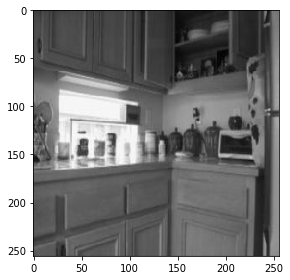

In [15]:
#看一下圖片
imshow(train_image[200])

In [16]:
#定義測試集array
test_image = np.empty((len(test_path),256,256,3))

In [17]:
#讀取測試集
for idx, path in enumerate(test_path):
    test_image[idx] = resize(imread(path, mode='RGB'), (256,256,3))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# Seperate the train and valid dataset

In [225]:
#拆分測試集與訓練集
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_image, train_label, test_size=0.1)

# Importing fast AI library

In [21]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [262]:
#指定模型存取的路徑
path= '/home/jovyan/Mid'

#參數設定
sz=256
arch=resnet152
max_zoom_size = 1.1

In [263]:
#定義data augmentation
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=max_zoom_size)
#讀取資料檔
data = ImageClassifierData.from_arrays(path=path, trn=(x_train, y_train), 
                                       val=(x_test,y_test), 
                                       tfms=tfms,
                                      test=test_image)

#建立訓練的模型
learn = ConvLearner.pretrained(arch, data, precompute=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 39/42 [00:13<00:01,  2.87it/s, loss=0.862]

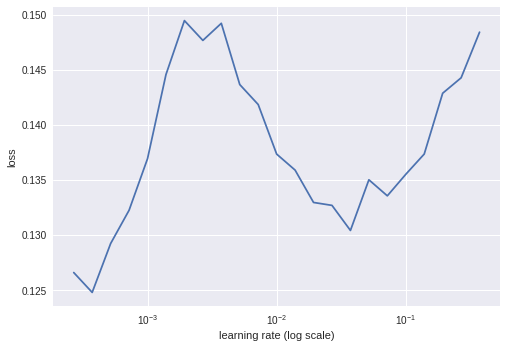

In [274]:
#找最佳的learning rate
lrf=learn.lr_find()
learn.sched.plot()

In [266]:
#建立不同的循環learning rate
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

learn.fit(lr, 3, cycle_len=1, cycle_mult=3, wds=1e-4) #第一個是learning rate, 第二個parameter是epochs

In [268]:
#將模型存起來
learn.save('224_lastlayer')
#讀取用learn.load
#learn.load('224_all')

In [269]:
#用TTA來延長測試時間，增加準確性
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

# Prediction

In [270]:
# 使用模型進行預測
log_preds = learn.predict(is_test=True)
log_preds.shape

(1500, 15)

In [271]:
#將預測的結果轉為class
log_preds_test = np.argmax(log_preds, axis=1)
log_preds_test.shape

(1500,)

In [272]:
#將結果與對應的標籤存起來
test_list = []
for i in df_test.values:
    test_list.append(i[0][55:-4])

In [273]:
#export 成 csv 檔案
final = pd.DataFrame({'id':test_list, 'class':log_preds_test})
final.to_csv('resnet152.csv',index=False)